In [ ]:
from data_loader import TimeWindowSegmenter
from data_loader import check_time_continuity

In [2]:
test_data_processor = TimeWindowSegmenter(
    df_path="real_world_2016.parquet",
    window_size=10,
    step_size=10,
    source_sampling_rate=50,
    time_column="timestamp",
    id_column='person_id',
    activity_column='activity_label',
    clean_columns=False,
    fix_timestamps=False,
    acc_columns=('acc_x', 'acc_y', 'acc_z'),
    gyr_columns=('gyr_x', 'gyr_y', 'gyr_z')
)
test_data_processor.df

,timestamp,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,activity_label,person_id
0,1435990454119,-9.57434,-2.02733,1.345060,-0.006546,-0.003098,-0.002441,climbingup,1
1,1435990454139,-9.56479,-1.99597,1.393450,-0.002274,-0.004166,0.002899,climbingup,1
2,1435990454159,-9.55122,-1.98445,1.411390,0.003067,-0.002029,0.003967,climbingup,1
3,1435990454178,-9.51335,-1.97557,1.426150,0.007339,-0.000961,0.003967,climbingup,1
4,1435990454198,-9.52959,-1.98187,1.453950,0.003067,-0.000961,0.001831,climbingup,1
...,...,...,...,...,...,...,...,...,...
2133987,1437229289880,-9.63908,-1.80135,0.084122,0.008972,-0.003601,0.042908,walking,15
2133988,1437229289919,-9.67114,-1.81438,0.062531,0.053833,-0.015350,0.068543,walking,15
2133989,1437229289939,-9.69185,-1.76408,0.161911,0.016449,0.001739,0.065338,walking,15
2133990,1437229289958,-9.70090,-1.77632,0.115936,-0.031616,0.008148,0.051453,walking,15


In [3]:
test_data_processor.resample_to(25)
test_data_processor.df

Resampling: 100%|██████████| 71/71 [00:03<00:00, 22.52it/s]


,timestamp,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,person_id,activity_label
0,2015-07-04 06:14:14.120,-9.569565,-2.011650,1.369255,-0.004410,-0.003632,0.000229,1.0,climbingup
1,2015-07-04 06:14:14.160,-9.532285,-1.980010,1.418770,0.005203,-0.001495,0.003967,1.0,climbingup
2,2015-07-04 06:14:14.200,-9.542025,-1.995025,1.430650,0.005737,-0.003098,0.002899,1.0,climbingup
3,2015-07-04 06:14:14.240,-9.538190,-2.008795,1.386680,0.006805,0.000641,0.001297,1.0,climbingup
4,2015-07-04 06:14:14.280,-9.536500,-2.006270,1.339430,0.008942,0.003845,0.004501,1.0,climbingup
...,...,...,...,...,...,...,...,...,...
1146209,2015-07-18 14:21:29.800,-9.666625,-1.711180,0.069885,0.025528,-0.004669,0.004456,15.0,walking
1146210,2015-07-18 14:21:29.840,-9.702445,-1.709315,0.132126,0.030334,-0.007874,0.026886,15.0,walking
1146211,2015-07-18 14:21:29.880,-9.647095,-1.804607,0.078724,0.020187,-0.006538,0.049316,15.0,walking
1146212,2015-07-18 14:21:29.920,-9.681495,-1.789230,0.112221,0.035141,-0.006805,0.066940,15.0,walking


In [5]:
2133992 / 1146214  

1.8617745028415287

In [9]:
data_processor = TimeWindowSegmenter(
  df_path="wsidm.parquet",
  window_size=10,   # 10 sekund
  step_size=10,     # 10 sekund - ramki się nie pokrywają w danych
)

Fixing timestamps...
Done fixing timestamps.


In [6]:
import numpy as np
from scipy.signal import welch
from scipy.fft import fft
import librosa
import pandas as pd

In [7]:
def dominant_frequency(signal, fs=20):
    """
    Dominująca częstotliwość to ta składowa częstotliwościowa sygnału, 
    która posiada największą moc (czyli największą amplitudę w widmie mocy). 
    Jest to częstotliwość, która dominuje energetycznie w analizowanym odcinku czasu.
    """
    freqs, psd = welch(signal, fs, nperseg=len(signal))
    dom_freq = freqs[np.argmax(psd)]
    return dom_freq

In [8]:
def spectral_entropy(signal, fs=20):
    """
     Entropia widmowa to miara nieuporządkowania lub losowości rozkładu widmowego sygnału. 
     Bazuje na teorii informacji (entropii Shannona) i opisuje, jak równomiernie rozłożona 
     jest energia sygnału w domenie częstotliwości.

     - Niska entropia oznacza, że energia jest skoncentrowana wokół kilku częstotliwości — sygnał jest bardziej "uporządkowany".
     - Wysoka entropia sugeruje rozproszenie energii po wielu częstotliwościach — sygnał jest bardziej "chaotyczny"
    """
    _, psd = welch(signal, fs, nperseg=len(signal))
    psd_norm = psd / np.sum(psd)  # normalizacja
    entropy = -np.sum(psd_norm * np.log2(psd_norm + 1e-12))  # dodajemy epsilon żeby uniknąć log(0)
    entropy /= np.log2(len(psd_norm))  # normalizacja do [0,1]
    return entropy

In [10]:
def spectral_energy(signal):
    """
    Energia widmowa to całkowita suma energii zawarta w widmie sygnału. 
    Można ją rozumieć jako "siłę" sygnału rozłożoną w dziedzinie częstotliwości.
    
    - Pomaga ocenić ogólną intensywność sygnału — im większa energia, tym silniejszy 
    jest sygnał w danym zakresie czasu.
    """
    spectrum = np.abs(fft(signal))**2
    energy = np.sum(spectrum) / len(spectrum) # normalizujemy do długości sygnału
    return energy

In [11]:
def spectral_centroid(signal, fs=20):
    """
    Centroid widmowy to "środek ciężkości" widma sygnału — informuje, gdzie 
    w domenie częstotliwości skoncentrowana jest energia.

    - Niski centroid: energia skupiona w niskich częstotliwościach (np. wolne ruchy).
    - Wysoki centroid: energia przesunięta w wyższe pasma.
    """
    freqs, psd = welch(signal, fs, nperseg=len(signal))
    psd_norm = psd / np.sum(psd)
    centroid = np.sum(freqs * psd_norm)
    return centroid

In [12]:
def spectral_bandwidth(signal, fs=20):
    """
    Szerokość pasma — odchylenie standardowe widma względem środka ciężkości (centroidu).

    - Małe pasmo sugeruje, że sygnał zawiera głównie wąski zakres częstotliwości.
    - Duże pasmo oznacza obecność wielu różnych składowych częstotliwościowych — np. złożone sygnały biologiczne.
    """
    freqs, psd = welch(signal, fs, nperseg=len(signal))
    psd_norm = psd / np.sum(psd)
    centroid = np.sum(freqs * psd_norm)
    bandwidth = np.sqrt(np.sum(((freqs - centroid) ** 2) * psd_norm))
    return bandwidth

In [13]:
def spectral_flatness(signal, fs=20):
    """
    Spłaszczenie widmowe to miara „szumowatości” sygnału. 
    - Wartość bliska 1: rozłożona energia, przypomina szum.
    - Wartość bliska 0: jedna dominująca częstotliwość (ton).
    """
    _, psd = welch(signal, fs, nperseg=len(signal))
    geometric_mean = np.exp(np.mean(np.log(psd + 1e-12)))  # epsilon zapobiega log(0)
    arithmetic_mean = np.mean(psd)
    flatness = geometric_mean / (arithmetic_mean + 1e-12)
    return flatness

In [14]:
def spectral_slope(signal, fs=20):
    """
    Nachylenie widmowe to kierunek trendu widma — informuje, czy amplitudy 
    rosną czy maleją wraz ze wzrostem częstotliwości.
    
    - Dodatnie: więcej energii w wyższych częstotliwościach.
    - Ujemne: dominacja niższych pasm.
    """
    freqs, psd = welch(signal, fs, nperseg=len(signal))
    X = freqs
    Y = 10 * np.log10(psd + 1e-12)
    slope = np.polyfit(X, Y, 1)[0]  # nachylenie regresji liniowej
    return slope

In [15]:
def spectral_rolloff(signal, fs=20, roll_percent=0.85):
    """
    Częstotliwość roll-off to taka, poniżej której znajduje się X% całkowitej energii.
    
    - Pomaga określić „górne pasmo” sygnału.
    - Typowe wartości X: 0.85 lub 0.95
    """
    freqs, psd = welch(signal, fs, nperseg=len(signal))
    cumulative_energy = np.cumsum(psd)
    threshold = roll_percent * cumulative_energy[-1]
    rolloff_idx = np.where(cumulative_energy >= threshold)[0][0]
    rolloff_freq = freqs[rolloff_idx]
    return rolloff_freq

In [16]:
def band_energy_ratio(signal, fs=20, low_band=(0.0, 10.0), high_band=(10.0, 20.0)):
    """
    Stosunek energii w dwóch zakresach częstotliwości — np. [0–10 Hz] vs. [10–20 Hz].
    - Przydatne do odróżniania typów ruchu (np. chód vs. bieganie).
    """
    freqs, psd = welch(signal, fs, nperseg=len(signal))

    low_mask = (freqs >= low_band[0]) & (freqs < low_band[1])
    high_mask = (freqs >= high_band[0]) & (freqs < high_band[1])

    low_energy = np.sum(psd[low_mask])
    high_energy = np.sum(psd[high_mask])
    
    ratio = low_energy / (high_energy + 1e-12)
    return ratio

In [17]:
def mfcc_features(signal, fs=50, n_mfcc=13):
    """
    Oblicza współczynniki MFCC dla danego sygnału. 
    UWAGA: MFCC ma sens tylko jak będziemy mieć większe FS niż 50Hz.

    Parametry:
    - signal: 1D array – sygnał wejściowy z jednej osi czujnika
    - fs: int – częstotliwość próbkowania (Hz), domyślnie 100 Hz
    - n_mfcc: int – liczba współczynników MFCC do zwrócenia

    Zwraca:
    - wektor cech: średnie wartości każdego z n_mfcc współczynników
    """
    mfcc = librosa.feature.mfcc(y=signal.astype(float), sr=fs, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)  # uśredniamy po czasie
    return mfcc_mean

In [18]:
def extract_features_from_window(window, fs=20, axes = ['ac_x', 'ac_y', 'ac_z', 'g_x', 'g_y', 'g_z']):
    features = []
    feature_names = []
    
    funcs = [
        ('dom_freq', dominant_frequency, [fs]),    
        ('entropy', spectral_entropy, [fs]),       
        ('energy', spectral_energy, []),           
        ('centroid', spectral_centroid, [fs]),     
        ('bandwidth', spectral_bandwidth, [fs]),   
        ('flatness', spectral_flatness, [fs]),     
        ('slope', spectral_slope, [fs]),           
        ('rolloff', spectral_rolloff, [fs]),       
        ('band_ratio', band_energy_ratio, [fs])    
    ]
    
    for axis in axes:
        signal = window[axis].astype(float).values
        for fname, func, extra_args in funcs:
            features.append(func(signal, *extra_args))
            feature_names.append(f"{axis}_{fname}")
    
    return features, feature_names

In [19]:
X_TEST = []
Y_TEST =[]
feature_names = None
for window in test_data_processor.segment():
        features, current_feature_names = extract_features_from_window(window,fs=50, axes=['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z'])
        if feature_names is None:
            feature_names = current_feature_names
        label = window['activity_label'].mode()[0]
        X_TEST.append(features)
        Y_TEST.append(label)

Segmenting:  99%|█████████▊| 71/72 [00:10<00:00,  6.77it/s]


In [21]:
features_test_df = pd.DataFrame(X_TEST, columns=feature_names)
features_test_df['label'] = Y_TEST

In [22]:
features_test_df

,acc_x_dom_freq,acc_x_entropy,acc_x_energy,acc_x_centroid,acc_x_bandwidth,acc_x_flatness,acc_x_slope,acc_x_rolloff,acc_x_band_ratio,acc_y_dom_freq,...,gyr_z_dom_freq,gyr_z_entropy,gyr_z_energy,gyr_z_centroid,gyr_z_bandwidth,gyr_z_flatness,gyr_z_slope,gyr_z_rolloff,gyr_z_band_ratio,label
0,3.4,0.645657,49342.295773,4.707314,2.917728,0.077823,-1.107101,7.0,14.564564,1.7,...,1.6,0.488239,434.422125,2.152527,1.366847,0.009613,-1.716768,2.9,168.385625,climbingup
1,3.5,0.598354,53229.583607,4.676409,3.014361,0.109513,-0.790642,6.9,17.082680,1.8,...,1.7,0.376185,886.734201,2.103545,1.104859,0.006296,-1.675325,3.0,314.446064,climbingup
2,3.6,0.709239,53975.873514,5.443892,4.611316,0.207061,-0.592020,9.9,6.401295,1.8,...,1.7,0.457637,1267.335866,2.243935,1.203856,0.007477,-1.768201,3.4,352.199108,climbingup
3,3.0,0.597051,52166.500346,4.289416,3.059442,0.098786,-1.019932,6.1,14.848756,1.5,...,1.6,0.501096,775.325586,2.053802,1.094038,0.007413,-1.825883,2.7,398.960873,climbingup
4,2.5,0.630502,52455.726373,4.245382,2.989108,0.105651,-0.954809,6.4,20.216501,1.3,...,1.3,0.610104,769.836181,2.636036,1.368648,0.011622,-1.815005,3.7,299.147409,climbingup
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2252,3.3,0.450399,50550.272090,4.317045,2.831980,0.057483,-0.769386,6.2,21.869516,3.3,...,3.3,0.570798,296.940999,3.406427,2.344204,0.052072,-1.058666,5.0,42.724841,walking
2253,3.4,0.511343,51500.509435,4.507697,3.100593,0.087711,-0.811947,6.6,9.621294,6.7,...,1.7,0.612162,329.108463,2.756427,2.006614,0.031237,-1.552414,5.0,62.020796,walking
2254,3.3,0.666713,50202.644216,3.951841,3.185869,0.123376,-0.953203,5.3,15.901449,0.3,...,1.7,0.669493,325.044376,2.583270,2.279253,0.052039,-1.238021,4.6,67.850243,walking
2255,3.3,0.580853,47585.537627,2.808030,2.950003,0.063462,-0.951745,3.5,23.797326,1.7,...,1.7,0.610819,332.502438,2.702462,1.823319,0.024400,-1.642209,4.1,96.458066,walking


In [23]:
X = []
Y = []
feature_names = None
for window in data_processor.segment():
    # print(check_time_continuity(window, sampling_rate_hz=50, timestamp_col='timestamp'))
    features, current_feature_names = extract_features_from_window(window)
    if feature_names is None:
        feature_names = current_feature_names
    label = window['Activity Label'].mode()[0]
    X.append(features)
    Y.append(label)

Segmenting: 100%|██████████| 250/250 [00:19<00:00, 12.68it/s]


In [24]:
features_train_df = pd.DataFrame(X, columns=feature_names)
features_train_df['label'] = Y

In [25]:
features_train_df

,ac_x_dom_freq,ac_x_entropy,ac_x_energy,ac_x_centroid,ac_x_bandwidth,ac_x_flatness,ac_x_slope,ac_x_rolloff,ac_x_band_ratio,ac_y_dom_freq,...,g_z_dom_freq,g_z_entropy,g_z_energy,g_z_centroid,g_z_bandwidth,g_z_flatness,g_z_slope,g_z_rolloff,g_z_band_ratio,label
0,1.3,0.483747,5197.094071,2.211988,2.127930,0.152184,-0.414171,3.2,14548.842979,2.6,...,1.3,0.477894,700.500160,1.745977,1.346696,0.091730,-1.697626,2.5,1.111383e+04,jogging
1,1.3,0.534395,6012.969788,1.982951,1.763206,0.138985,-1.084607,2.6,846.153675,2.6,...,1.3,0.364055,922.877970,1.551187,0.975226,0.048895,-1.434099,1.4,6.099058e+03,jogging
2,1.2,0.440927,6153.479572,1.755256,1.530200,0.119331,-1.071413,2.4,489432.225896,2.5,...,1.3,0.383075,928.394117,1.434671,0.884205,0.048784,-1.954359,1.3,1.256587e+04,jogging
3,1.3,0.471498,7823.257321,2.097153,1.876074,0.135096,-0.259951,2.6,1875.637923,2.5,...,1.3,0.507960,1191.271070,1.750354,1.235658,0.110080,-1.941174,2.5,7.742417e+03,jogging
4,1.3,0.500361,7769.688932,1.954715,1.698712,0.119240,-1.157793,2.6,13386.808911,2.5,...,1.3,0.354522,1523.685387,1.508183,0.809144,0.045773,-1.921978,1.4,2.883398e+04,jogging
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4629,1.9,0.614466,38411.544763,1.427142,1.304697,0.094251,-2.322954,2.0,137485.378337,0.9,...,1.0,0.341772,3546.413480,1.055981,0.569005,0.015362,-3.475706,1.0,2.345755e+06,walking
4630,2.0,0.566765,45511.859992,2.105939,1.230247,0.118740,-1.886110,2.6,49725.204003,1.0,...,1.0,0.294837,3279.440105,1.114555,0.527553,0.012050,-3.083012,1.1,6.149590e+05,walking
4631,0.1,0.397476,18779.818012,0.357023,0.644968,0.018656,-3.137074,0.7,97077.817348,0.2,...,1.0,0.590062,1197.127513,0.928893,0.684388,0.029817,-3.584319,1.1,1.399125e+04,walking
4632,0.1,0.463099,11621.851249,0.432016,0.859173,0.037946,-2.585967,1.0,406665.848942,0.1,...,1.0,0.583888,1027.946566,0.987466,0.784929,0.034722,-3.713101,1.2,5.573681e+04,walking


In [ ]:
correlation_matrix = features_train_df.drop('label', axis=1).corr()
correlation_matrix

,ac_x_dom_freq,ac_x_entropy,ac_x_energy,ac_x_centroid,ac_x_bandwidth,ac_x_flatness,ac_x_slope,ac_x_rolloff,ac_x_band_ratio,ac_y_dom_freq,...,g_y_band_ratio,g_z_dom_freq,g_z_entropy,g_z_energy,g_z_centroid,g_z_bandwidth,g_z_flatness,g_z_slope,g_z_rolloff,g_z_band_ratio
ac_x_dom_freq,1.000000,0.365049,0.046852,0.709827,0.233687,0.391829,0.494993,0.503727,-0.011998,0.329170,...,-0.010278,0.170706,0.082943,0.131998,0.186669,0.107994,0.093126,0.124237,0.162272,0.003305
ac_x_entropy,0.365049,1.000000,-0.248839,0.739896,0.753963,0.899466,0.420997,0.806198,-0.021630,0.108031,...,-0.008119,0.347325,0.532608,-0.147882,0.505875,0.459257,0.471092,0.325921,0.503975,0.005225
ac_x_energy,0.046852,-0.248839,1.000000,-0.101266,-0.332330,-0.348975,-0.129738,-0.211301,0.013369,-0.037745,...,0.008400,-0.286608,-0.590557,0.339406,-0.505650,-0.579707,-0.541979,-0.474989,-0.533553,0.011331
ac_x_centroid,0.709827,0.739896,-0.101266,1.000000,0.715217,0.795834,0.801826,0.920068,-0.023102,0.370656,...,-0.017365,0.381817,0.318706,0.049252,0.473606,0.359891,0.339676,0.352894,0.440418,0.005150
ac_x_bandwidth,0.233687,0.753963,-0.332330,0.715217,1.000000,0.829354,0.737476,0.882060,-0.020460,0.147092,...,-0.015935,0.426495,0.502604,-0.084845,0.602989,0.541497,0.520402,0.495731,0.588372,0.009450
ac_x_flatness,0.391829,0.899466,-0.348975,0.795834,0.829354,1.000000,0.600002,0.867398,-0.020660,0.158244,...,-0.013091,0.443561,0.600739,-0.109403,0.639508,0.584823,0.588158,0.489291,0.633312,-0.000237
ac_x_slope,0.494993,0.420997,-0.129738,0.801826,0.737476,0.600002,1.000000,0.781289,-0.028287,0.348592,...,-0.022916,0.366532,0.248528,0.043599,0.467095,0.362630,0.314578,0.436252,0.430081,0.002722
ac_x_rolloff,0.503727,0.806198,-0.211301,0.920068,0.882060,0.867398,0.781289,1.000000,-0.025438,0.270074,...,-0.016338,0.420289,0.421859,-0.019154,0.558236,0.458513,0.443567,0.422710,0.533691,0.010098
ac_x_band_ratio,-0.011998,-0.021630,0.013369,-0.023102,-0.020460,-0.020660,-0.028287,-0.025438,1.000000,-0.011483,...,0.051791,-0.013846,-0.026005,0.012872,-0.024447,-0.019011,-0.017500,-0.006337,-0.022631,-0.000306
ac_y_dom_freq,0.329170,0.108031,-0.037745,0.370656,0.147092,0.158244,0.348592,0.270074,-0.011483,1.000000,...,-0.015432,0.091934,-0.016707,0.224076,0.090999,0.045407,-0.013495,0.124319,0.060818,-0.003458


In [ ]:
averaged_features = []

methods = ['dom_freq', 'entropy', 'energy', 'centroid', 'bandwidth', 'flatness', 'slope', 'rolloff', 'band_ratio']
sensors = ['ac', 'g']

for method in methods:
    for sensor in sensors:
        columns_to_average = [col for col in features_train_df.columns if method in col and sensor in col]
        
        averaged_value = features_train_df[columns_to_average].mean(axis=1)
        
        averaged_features.append(averaged_value)

averaged_df = pd.DataFrame(averaged_features).T
averaged_df.columns = [f"{method}_{sensor}" for method in methods for sensor in sensors]

correlation_matrix = averaged_df.corr()

correlation_matrix

,dom_freq_ac,dom_freq_g,entropy_ac,entropy_g,energy_ac,energy_g,centroid_ac,centroid_g,bandwidth_ac,bandwidth_g,flatness_ac,flatness_g,slope_ac,slope_g,rolloff_ac,rolloff_g,band_ratio_ac,band_ratio_g
dom_freq_ac,1.000000,0.422502,0.376519,0.151077,0.170933,0.175047,0.783719,0.469299,0.315047,0.306990,0.442823,0.239208,0.613238,0.410942,0.590251,0.411325,-0.015807,0.003364
dom_freq_g,0.422502,1.000000,0.418971,0.469446,-0.089220,-0.082637,0.582303,0.744659,0.504627,0.534109,0.519209,0.533658,0.533774,0.550175,0.574540,0.663364,-0.019345,-0.002612
entropy_ac,0.376519,0.418971,1.000000,0.637590,-0.400247,-0.391742,0.704866,0.529475,0.772355,0.479212,0.912028,0.532198,0.442600,0.276765,0.799925,0.533561,-0.027188,0.002038
entropy_g,0.151077,0.469446,0.637590,1.000000,-0.451355,-0.450145,0.414846,0.771392,0.632111,0.838339,0.691655,0.883741,0.357295,0.538760,0.539650,0.819473,-0.041054,-0.015773
energy_ac,0.170933,-0.089220,-0.400247,-0.451355,1.000000,0.998118,-0.009137,-0.153171,-0.334215,-0.212707,-0.369201,-0.353035,0.035028,0.086041,-0.187043,-0.206831,0.005504,-0.005849
energy_g,0.175047,-0.082637,-0.391742,-0.450145,0.998118,1.000000,-0.007405,-0.151681,-0.332097,-0.216371,-0.363001,-0.353445,0.029838,0.079906,-0.184799,-0.206864,0.005968,-0.005916
centroid_ac,0.783719,0.582303,0.704866,0.414846,-0.009137,-0.007405,1.000000,0.704836,0.740003,0.548443,0.794826,0.490796,0.859913,0.573676,0.934073,0.661641,-0.027255,-0.000808
centroid_g,0.469299,0.744659,0.529475,0.771392,-0.153171,-0.151681,0.704836,1.000000,0.690826,0.888853,0.686280,0.878723,0.701179,0.823656,0.727147,0.976906,-0.033406,-0.009747
bandwidth_ac,0.315047,0.504627,0.772355,0.632111,-0.334215,-0.332097,0.740003,0.690826,1.000000,0.673883,0.872912,0.661390,0.760037,0.544548,0.901398,0.705904,-0.025942,0.001115
bandwidth_g,0.306990,0.534109,0.479212,0.838339,-0.212707,-0.216371,0.548443,0.888853,0.673883,1.000000,0.641135,0.927273,0.590542,0.861045,0.615219,0.940438,-0.027214,-0.014947


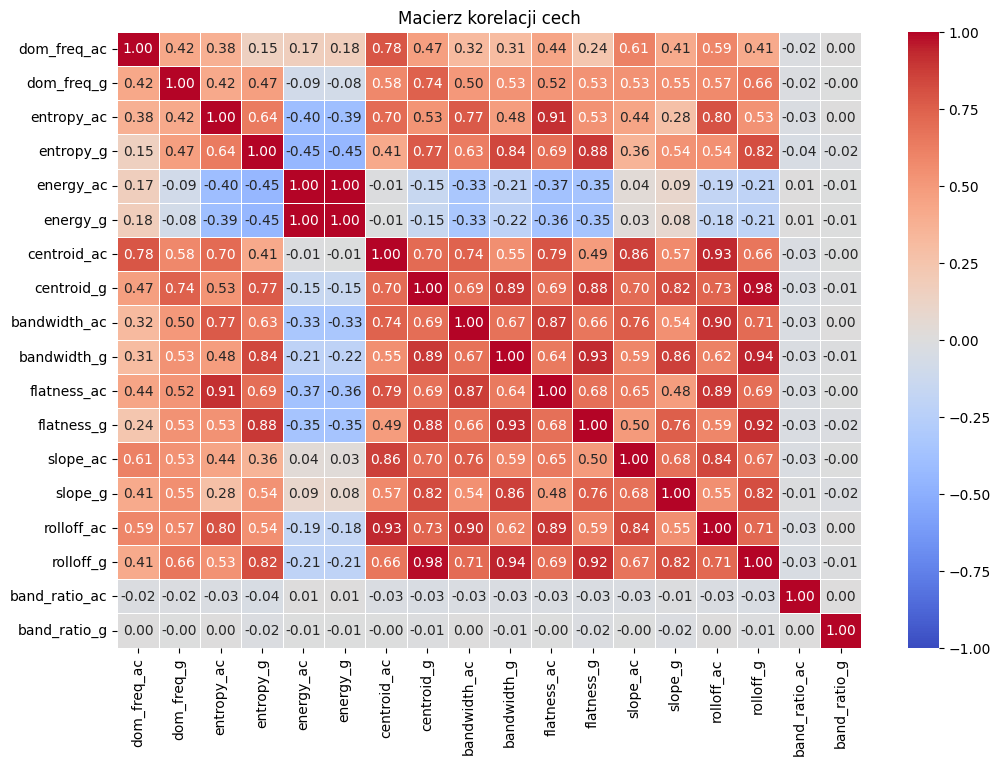

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

plt.title('Macierz korelacji cech')
plt.show()